In [ ]:
# .from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Install require package
# ! pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
# # ! pip install albumentations
# # ! pip install opencv
# ! apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python #install openCV
# ! pip install -U segmentation-models-pytorch albumentations --user  # install albumentation
# ! pip install -U segmentation-models-pytorch
# ! pip install icecream
# ! pip install imgaug

In [14]:
# import required module
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2  #import Image read package
import albumentations as albu  # import required packages for data augmentation
from icecream import ic

# import modules for data extraction, augmentation, and preprocessing
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import keras

In [15]:
# Set directory of files
DATA_DIR = r'C:\Users\user\Desktop\Project KCL\histology\data\annotated histology'



xTrainDir = os.path.join(DATA_DIR,'train/image') #set Train Images dir
bodyTrainDir = os.path.join(DATA_DIR,'train/epidermis_mask')  #set Train body Label Images dir
# psoriasisTrainDir = os.path.join(DATA_DIR,'Psoriasis_Train_Label_Plaque')

xValidDir = os.path.join(DATA_DIR,'valid/image')   #set Validation Images dir
bodyValidDir = os.path.join(DATA_DIR,'valid/epidermis_mask')   #set Validation body Label Images dir 
# psoriasisValidDir = os.path.join(DATA_DIR,'Psoriasis_Valid_Label_Plaque')

xTestDir = os.path.join(DATA_DIR,'test/image')  #set Test Images dir
bodyTestDir = os.path.join(DATA_DIR,'test/epidermis_mask')  #set Test body Label Images dir
# psoriasisTestDir = os.path.join(DATA_DIR,'Psoriasis_Valid_Label_Plaque')

In [16]:
# Helper function for data visualization

def visualize(**images):
  n = len(images)
  plt.figure(figsize = (16,5)) 
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
  plt.show()

In [17]:
#  Define class for data extraction, augmentation, and preprocessing

class Dataset(BaseDataset):

  CLASSES = ['body','background'] #Classes of Image mask
  # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
  #            'tree', 'signsymbol', 'fence', 'car',
  #            'pedestrian', 'bicycclist', 'unlabelled']

  def __init__(
      self,
      imagesDir,
      annotationDir,
      classes = None,
      augmentation = None,
      preprocessing = None,
  ):
    self.ids = os.listdir(imagesDir)   
    self.imagesFps = [os.path.join(imagesDir,imageID) for imageID in self.ids]  
    self.annotationsFps = [os.path.join(annotationDir,imageID) for imageID in self.ids]
    self.classValues = [self.CLASSES.index(cls.lower()) for cls in classes]
    self.augmentation = augmentation
    self.preprocessing = preprocessing

  def __getitem__(self,i):

    # read data
    image  = cv2.imread(self.imagesFps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.stack(image)
    annotation = cv2.imread(self.annotationsFps[i],0)  

    #extract certain classes from annotation (Like- Body)
    annotations = [(annotation == v) for v in self.classValues]
    annotation = np.stack(annotations, axis = -1).astype('float')
    annotation = np.logical_not(annotation)
    annotation = np.array(annotation, dtype='int16')

    # apply augmentations
    if self.augmentation:
      sample = self.augmentation(image=image, mask=annotation)
      image, annotation = sample['image'], sample['mask']

    # Apply preprocessing
    if self.preprocessing:
      sample = self.preprocessing(image=image, mask=annotation)
      image, annotation = sample['image'], sample['mask']
    
    return image,annotation

  def __len__(self):
    return len(self.ids)


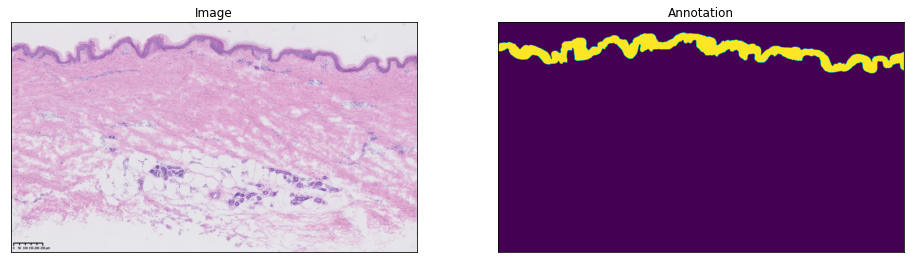

In [18]:
# Let's look at data we have

dataset = Dataset(xTrainDir,bodyTrainDir,classes=['Body']) # Check specific class to see the Image annotation

image, annotation = dataset[3] # get a sample

visualize(
    image = image,
    annotation = annotation.squeeze(),
)

In [34]:
# Augmented training data to increase the datasets
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(      
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=90,
        width_shift_range= 0.2,
        height_shift_range=0.2,
        brightness_range=None,
        shear_range=0.2,
        zoom_range=0.2,
        channel_shift_range=0.0,
        fill_mode="constant",
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0,
        dtype=None,)


from icecream import ic
for j in range(64):
  img, mask = dataset[j]
  x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
  y = img_to_array(mask)
  x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
  y = y.reshape((1,) + y.shape)
  ic(j)
  # the .flow() command below generates batches of randomly transformed images
  # and saves the results to the `preview/` directory
  i = 1
  imgFile = ('image',str(j))#,'_',str(i))
  imgFile = ''.join(imgFile)
  maskFile = ('mask',str(j))#,'_',str(i))
  maskFile = ''.join(maskFile

  for X_batch in datagen.flow(x, batch_size=1, save_to_dir='images', save_prefix='aug', save_format='png'):
                     if i>100:
                         break

#       if i > 100:
#           break  # otherwise the generator would loop indefinitely

SyntaxError: invalid syntax (<ipython-input-34-a3cdcd686bc0>, line 45)